# Vectorización de texto como una generalización de los feature_sets
---
En el reto anterior vimos que la noción de modelos de máxima entropía implica la consideración de varios features que quedaban codificados en funciones que  escribiamos como $f_a(t, o)$. Donde para el caso particular de un modelo de máxima entropia considerabamos el cálculo de las probabilidades como combinaciones lineales entre los features y sus respectivos pesos $\theta_i$, de manera que: 

$$
\theta_1 f_1(t, o) + \theta_2 f_2(t, o) + \dots
$$

Si en general consideramos $n$ features o atributos por cada documento de texto, tenemos un conjunto de parámetros que se pueden escribir como componentes de un vector $[\theta_1,  \dots, \theta_n]$ y lo mismo para los features así: $[f_1,  \dots, f_n]$, como sabemos que estos features toman valores entre cero y uno tenemos que un vector de features podría verse algo como: 

$$
[1, 1, 0, \dots, 0, 0, 1]
$$

de manera que la combinacion lineal de features y parámetros se puede escribir como el producto de vectores: 

$$
\theta_1 f_1(t, o) + \theta_2 f_2(t, o) + \dots = [\theta_1,  \dots, \theta_n] \cdot [f_1,  \dots, f_n] 
$$

Y es así como decimos que hemos vectorizado un texto en términos de sus features. Esta noción general de representación de texto resultará más cómoda para el reto que resolveremos en este notebook. 

## Trabajando con un dataset pre-procesado (modelo binario +/-)

Ahora trabajaremos con el dataset: **processed_acl** de la fuente: http://www.cs.jhu.edu/~mdredze/datasets/sentiment/ que se presento en la clase de presentación del reto, el cual ya tiene pre-procesados los atributos de los textos junto con la etiqueta de sentimiento de cada uno, que puede ser `positiva` o `negativa`.  

---

In [1]:
# el dataset lo tengo guardado en mi Drive, asi que 
# tu deberás hacer algo similar para poder ejecutar este notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Ahora exploramos la estructura del dataset, **considerando solamente la categoría books**:

In [2]:
# aqui modificas tus rutas, segun lo que tengas en tu Drive personal
f = open('/content/drive/My Drive/processed_acl/books/negative.review', 'r')
text_negative = f.read()
f.close()
f = open('/content/drive/My Drive/processed_acl/books/positive.review', 'r')
text_positive = f.read()
f.close()

In [3]:
# ejemplo de un texto pre-procesado
text_negative.split('\n')[0]

"avid:1 your:1 horrible_book:1 wasted:1 use_it:1 the_entire:1 money.i:1 i_lit:1 i_read:1 lit:1 i_would:1 relationship:1 read:1 a_<num>:1 reader_and:1 reader:1 suffering:1 fire_one:1 i_had:1 year_old:2 gotten:1 horrible:3 lit_this:1 world...don't:1 my:2 one_star:1 headache_the:1 this_book:5 mom:1 was_horrible:1 friend:1 book_horrible:1 star_i:1 back:1 avid_reader:1 than_one:1 life:1 copy:1 rate_it:1 rate:1 my_mom:1 man:1 book_was:1 half:1 on_fire:1 and_then:1 reading_this:1 so:1 lower:1 i_could:1 <num>_year:2 than:1 time:2 half_of:1 time_spent:1 then:1 book:6 and_picked:1 possible:1 spent:1 old_man:1 up_after:1 one:2 horrible_if:1 one_less:1 part:1 was:2 entire:1 less_copy:1 to_rate:1 my_life:1 about_the:1 your_money.i:1 an_avid:1 if:1 the_relationship:1 use:1 a_headache:1 fire:1 lower_than:1 reading:1 a_friend:1 picked:1 purposes:1 then_got:1 waste_your:1 after_my:1 friend_i:1 old:2 man_and:1 and_i:1 world...don't_waste:1 book_on:1 part_about:1 copy_in:1 book_back:1 book_wasted:1 have_

---
Cada línea del dataset es un string tipo diccionario (donde cada llave-valor son el feature y el numero de veces que aparece en el texto), al final la categoria aparece como `#label#:` y el valor negative o positive, según el caso:

```
feature1: 1 feature2: 2, ... #label#: negative

```

Así, de esta estructura podemos considerar un tipo de vectorización no-binaria donde cada elemento del vector de texto, es el número de veces que un feature es observado en el documento, si los features los consideramos como diferentes palabras clave entonces a este proceso se le denomina vectorizacion por bolsa de palabras o **Bag of Words (BOW)**

|       | word_1 | word_2 | ... | word_n |
|-------|--------|--------|-----|--------|
| doc_1 | 1      | 2      |     | 0      |
| doc_2 | 0      | 2      |     | 1      |
| doc_3 | 3      | 1      |     | 1      |

por ejemplo, el vector del documento `doc_1` sería :

$$
[1, 2, \dots, 0]
$$

---

In [6]:
# Aquí construirmos un bag of words con su respectiva distribucion de frecuencias
import nltk
bag_of_words = []
for line in text_negative.split('#label#:negative\n'):
  for key_value in line.split(' '):
           bag_of_words.append(key_value.split(':')[0]) 
for line in text_positive.split('#label#:positive\n'):
  for key_value in line.split(' '):
           bag_of_words.append(key_value.split(':')[0]) 
fdist = nltk.FreqDist(bag_of_words)
print('considerando todo el BOW tendríamos: {} features posibles'.format(len(fdist)))

considerando todo el BOW tendríamos: 195888 features posibles


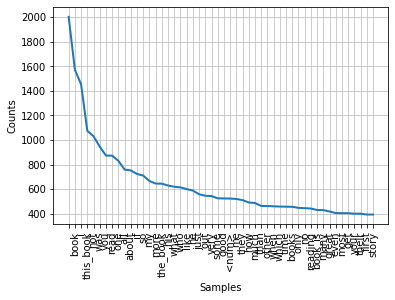

In [7]:
# consideramos filtrar solo a un sub-grupo de features (los más frecuentes)
fdist.plot(50)

In [8]:
# escogemos armar un BOW reducido solo con las palabras más frecuentes
reduced_bow = [w for w in set(bag_of_words) if fdist[w]>50]

In [9]:
#aquí tendriamos la longitud de los vectores para cada texto
len(reduced_bow)

813

In [12]:
#ahora vamos a crear el vector por cada documento
import numpy as np

vectors = []
labels = []
for line in text_negative.split('#label#:negative\n'):
  line_dict = {keyval.split(':')[0]: int(keyval.split(':')[1]) for keyval in line.split(' ') if len(keyval.split(':'))==2}
  line_vector = []
  for word in reduced_bow:
    if word in line_dict.keys():
      line_vector.append(line_dict[word])
    else:
      line_vector.append(0)
  vectors.append(line_vector)
  labels.append('negative')

for line in text_positive.split('#label#:positive\n'):
  line_dict = {keyval.split(':')[0]: int(keyval.split(':')[1]) for keyval in line.split(' ') if len(keyval.split(':'))==2}
  line_vector = []
  for word in reduced_bow:
    if word in line_dict.keys():
      line_vector.append(line_dict[word])
    else:
      line_vector.append(0)
  vectors.append(line_vector)
  labels.append('positive')

vectors = np.array(vectors)

In [13]:
vectors.shape

(2002, 813)

In [14]:
vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [15]:
from sklearn.model_selection import train_test_split

train_vectors, test_vectors, train_labels, test_labels = train_test_split(vectors, labels, test_size=0.2, random_state=42)
print('longitud dataset de entrenamiento: {}'.format(len(train_vectors)))
print('longitud dataset de evaluación: {}'.format(len(test_vectors)))

longitud dataset de entrenamiento: 1601
longitud dataset de evaluación: 401


---
Vamos a considerar para el entrenamiento la implementación de Naive Bayes de Scikit Learn, en particular el Naive Bayes multinomial que es apropiado para este caso de vectores que  representan conteos de palabras. 

Ver referencia:

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB 

---

In [16]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(train_vectors, train_labels)
clf.score(test_vectors, test_labels) # este score nos devuelve el accuracy promedio. 

0.7855361596009975

---
Aquí calculamos ahora la matríz de confusión, como lo vimos en la clase de métricas de modelos donde estan cantidades como los verdaderos positivos, etc. 

Usamos scikit learn para calcular la matriz y la libreria Seaborn para dibujar el mapa de calor. Recuerda que en un caso ideal de clasificador perfecto, la matriz de confusion deberia tener todos los elementos por fuera de la diagonal como cero. 

---

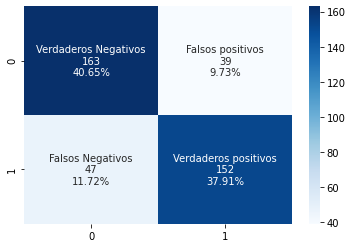

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, clf.predict(test_vectors))
group_names = ['Verdaderos Negativos','Falsos positivos','Falsos Negativos','Verdaderos positivos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels,fmt='', cmap='Blues')

## Trabajando con un dataset pre-procesado (modelo multicategoria 1-5)

Aquí trabajaremos con el dataset: **processed_stars** , el cual ya tiene pre-procesados los atributos de los textos junto con la etiqueta de sentimiento de cada uno, que ahora en este caso toma valores en una escala numérica de 1 a 5. 

---

In [18]:
!pip install stanza

     |████████████████████████████████| 342 kB 37.3 MB/s 


In [19]:
f = open('/content/drive/My Drive/processed_stars/books/all_balanced.review', 'r')
text = f.read()
f.close()
text
text.split('\n')[0]

'helpful:1 voices_of:1 the_levels:1 it:1 only_knew:1 "if_i:1 guidance_in:1 departing_one:1 familiarize:1 meaning:1 self_is:1 can_be:1 knowledge:3 koan\'s_since:1 be:1 experiences_actions:1 spiritually_the:1 you_to:1 collection:1 with_not:1 as:1 disciplines_spiritually:1 levels:1 that_i:1 work_but:1 to_anything:1 each_statement:1 much_much:1 dhu-l-nun:1 a_quote:1 badruddin:1 all_through:1 sets:1 but:1 chapters_offer:1 actions_remembrances:1 one_from:1 revisited_for:1 sufisim:1 some:1 fallow:1 upon:1 which:1 bistami_and:1 more_a:1 not_only:1 bayazid:1 path_of:1 awakening:1 the_many:1 intellective_sufis:1 experiences:1 and_all:1 great:3 and_much:1 yourself:1 through_the:1 guidance\'s._the:1 in_a:1 upon_awakening:1 meaning_for:1 introducing_hadiths:1 fantasic:1 guidance\'s.:1 had_taken:1 point_it:1 contemplation_in:1 value:1 quote_from:1 sincerity:1 remembrances_and:1 of_guidance:1 compared:1 find_no:1 eternal_intellective:1 to_the:1 touch:1 be_compared:1 actions:1 compared_some:1 is_true:

---
Ahora en este caso, cada línea del dataset es un string tipo diccionario con el feature y el numero de veces que aparece en el texto, al final la categoria aparece como `#label#:` y el valor numérico, seguún el caso:

```
feature1: 1 feature2: 2, ... #label#: 2.0

```

Aquí consideraremos el mismo tipo de vectorización usado en el caso anterior con el dataset **processed_stars**

---

In [20]:
import nltk
bag_of_words = []
for line in text.split('\n'):
  seq = line.split('#label#:')
  if len(seq)==2:
    for key_value in seq[0].split(' '):
      bag_of_words.append(key_value.split(':')[0]) 
fdist = nltk.FreqDist(bag_of_words)
print('considerando todo el BOW tendríamos: {} features posibles'.format(len(fdist)))

considerando todo el BOW tendríamos: 401727 features posibles


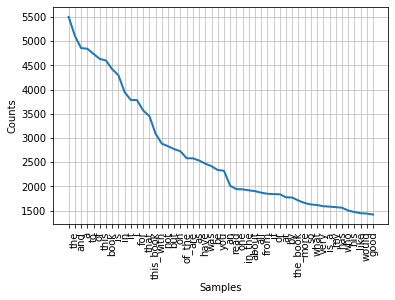

In [21]:
# la distribucion de frecuencias es diferente por que el corpus que tenenmos 
# es más grande y más general.
fdist.plot(50)

In [23]:
reduced_bow = [w for w in set(bag_of_words) if fdist[w]>100]
len(reduced_bow)

1214

In [24]:
import numpy as np

vectors = []
labels = []
for line in text.split('\n'):
  seq = line.split('#label#:')
  if len(seq)==2:
    line_dict = {keyval.split(':')[0]: int(keyval.split(':')[1]) for keyval in seq[0].split(' ') if len(keyval.split(':'))==2}
    line_vector = []
    for word in reduced_bow:
      if word in line_dict.keys():
        line_vector.append(line_dict[word])
      else:
        line_vector.append(0)
    vectors.append(line_vector)
    labels.append(float(seq[1]))

vectors = np.array(vectors)

In [25]:
vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [27]:
set(labels)                                              

{1.0, 2.0, 4.0, 5.0}

In [28]:
from sklearn.model_selection import train_test_split

train_vectors, test_vectors, train_labels, test_labels = train_test_split(vectors, labels, test_size=0.1, random_state=42)
print('longitud dataset de entrenamiento: {}'.format(len(train_vectors)))
print('longitud dataset de evaluación: {}'.format(len(test_vectors)))

from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(train_vectors, train_labels)
clf.score(test_vectors, test_labels)

longitud dataset de entrenamiento: 4950
longitud dataset de evaluación: 551


0.5081669691470054

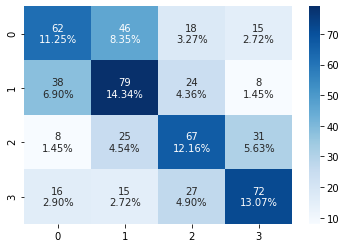

In [29]:
cm = confusion_matrix(test_labels, clf.predict(test_vectors))

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

annot = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
annot = np.asarray(annot).reshape(4,4)
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues')

---
Como caso curioso, en la siguiente celda consideramos el entrenamiento de otros modelos de clasificación implementados en scikit. Con los conocimientos que ahora tienes, puedes explorar con total libertad el zoologico de modelos de clasificación que existen !! 

---

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB

clf = RandomForestClassifier().fit(train_vectors, train_labels)
print('Score for RandomForestClassifier = {}'.format(clf.score(test_vectors, test_labels)))

clf = BernoulliNB().fit(train_vectors, train_labels)
print('Score for Naive Bayes Bernoulli = {}'.format(clf.score(test_vectors, test_labels)))

clf = ComplementNB().fit(train_vectors, train_labels)
print('Score for Naive Bayes Complement = {}'.format(clf.score(test_vectors, test_labels)))

Score for RandomForestClassifier = 0.49364791288566245
Score for Naive Bayes Bernoulli = 0.43920145190562615
Score for Naive Bayes Complement = 0.49909255898366606


# Ahora, para finalizar ...
--- 

Como puedes ver entrenar un modelo de más de dos clases es más desafiante, el accuracy del 50% nos indica que usar features tipo Bag of words y filtrando por las palabras más comunes del corpus NO es suficiente. ¿que otros tipos de vectorizaciones y selección de features crees que pueden ayudarnos a tener un mejor algoritmo de clasificación en escala numérica discreta?

También, es importante que intentes un ejercicio completo de vectorización desde cero con el dataset **sorted_data** que también encuentras en http://www.cs.jhu.edu/~mdredze/datasets/sentiment/. 

Una guía completa de vectorización de texto la encuentras en la documentación de Scikit: 

https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html


Con esto hemos terminado definitivamente el curso, ¿Verdad que aprendiste un monton de cosas?. Cuentame en los comentarios de la clase final, que te parecio el curso y que otras cosas esperas en los próximos cursos de la ruta de NLP. 


Espero que hayas disfrutado este viaje de aprendizaje. 